### Imports

In [1]:
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import matplotlib
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from os.path import exists
import os
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
%matplotlib inline

matplotlib.style.use('ggplot')

### Running the Modules Implementation Notebook

In [218]:
# note that if you change smth there, you have to run this again
%run NN_Implementation_Modules.ipynb

### Implementation of Optimizers

Feel free to add prints for understanding in "debug-mode" :)

In [3]:
def sgd(x, dx, lr, state):
    """
    Implementation of sgd with storing old gradients in state. Google to understand how setdefault works.

    :param lr:     learning rate, default value is 0.1
    :param state:  empty dictionary to store gradients throught the update process
    """
    
    state.setdefault('old_grad', {})
    
    i = 0 
    for current_layer_x, current_layer_dx in zip(x,dx): 
        for current_x, current_dx in zip(current_layer_x,current_layer_dx):
            current_old_grad = state['old_grad'].setdefault(i, np.zeros_like(current_dx))
            current_old_grad = current_old_grad + current_dx
            state['old_grad'][i] = current_old_grad
            if current_old_grad.shape[0] == 1:
                current_x = current_dx.reshape(current_old_grad.shape)
            np.add(current_x, lr*(-current_old_grad), out=current_x)
            i += 1     

In [150]:
def sgd_momentum(x, dx, lr, state,alfa=0.9):
    """
    Implementation of sgd momentum with storing old gradients in state.

    :param lr:     learning rate, default value is 0.1
    :param state:  empty dictionary to store gradients throught the update process
    """
    
    state.setdefault('old_grad', {})
    
    i = 0 
    for current_layer_x, current_layer_dx in zip(x,dx): 
        for current_x, current_dx in zip(current_layer_x,current_layer_dx):
            current_old_grad = state['old_grad'].setdefault(i, np.zeros_like(current_dx))
            current_old_grad = alfa*current_old_grad - lr*current_dx
            state['old_grad'][i] = current_old_grad
            if current_old_grad.shape[0] == 1:
                current_x = current_x.reshape(current_old_grad.shape)
            np.add(current_x, current_old_grad, out=current_x)
            i += 1     

In [148]:
def adam(x, dx, lr, state,beta1 = 0.9,beta2 = 0.999,epsilon = 1e-8):
    """
    Implementation of Adam

    :param lr:     learning rate, default value is 0.1
    :param state:  empty dictionary to store gradients throught the update process
    """
    
    i = 0 
    state.setdefault('old_m', {})
    state.setdefault('old_v',{})
    state.setdefault('t', 0)
    for current_layer_x, current_layer_dx in zip(x,dx): 
        state['t']+=1
        for current_x, current_dx in zip(current_layer_x,current_layer_dx):
            current_old_m = state['old_m'].setdefault(i, np.zeros_like(current_dx))
            current_old_v = state['old_v'].setdefault(i, np.zeros_like(current_dx))
            current_old_m = beta1*current_old_m + (1-beta1)*current_dx
            current_old_v = beta2*current_old_v + (1-beta2)*(current_dx**2)
            m_unbiased = current_old_m/(1-(beta1**state['t']))
            v_unbiased = current_old_v/(1-(beta2**state['t']))
            state['old_m'][i] = current_old_m
            state['old_v'][i] = current_old_v
            if current_old_m.shape[0] == 1:
                current_x = current_dx.reshape(current_old_m.shape)
            if current_old_v.shape[0] == 1:
                current_x = current_dx.reshape(current_old_v.shape)
            np.add(current_x, lr*(-m_unbiased/(np.sqrt(v_unbiased)+epsilon)), out=current_x)
            i += 1     

### Batch Generator

Google to understand how python's `generator` objet differs from iterator.


In [149]:
def get_batches(X, Y, batch_size):
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Training algorithm

In [7]:
# TODO: Training Proccess
def train(X_train,y_train,n_epoch,batch_size,lr,state,sgd_momentum_alfa=0.9,optim_method='sgd'):
    loss_history = []

    for i in range(n_epoch):
        for x_batch, y_batch in get_batches(X_train, y_train, batch_size):
            net.zeroGradParameters()

            # Forward Pass
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward Pass
            bp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, bp)

            # Update 
            if(optim_method=='sgd'):
                sgd(net.getParameters(), net.getGradParameters(),lr,state)
            elif(optim_method=='sgd_momentum'):
                sgd_momentum(net.getParameters(), net.getGradParameters(),lr,state,sgd_momentum_alfa)
            else:
                adam(net.getParameters(), net.getGradParameters(),lr,state)

                


            loss_history.append(loss)

        # Visualize
        display.clear_output(wait=True)
        plt.figure(figsize=(8, 6))

        plt.title("Training loss")
        plt.xlabel("#iteration{0}".format(i+1))
        plt.ylabel("loss")
        plt.plot(loss_history, 'b')
        plt.show()

        print('Current loss: %f' % loss)    

# Toy Example

Simple example for debugging implementation.

### Data Generation

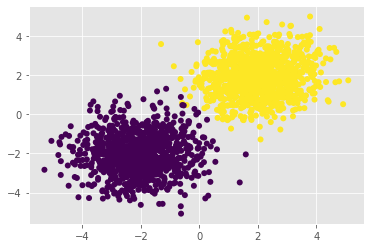

In [156]:
# Generate some data
N = 1024

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y]) # one-hot encoding Y

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

### Network Architecture

Try architecture that will perform `logistic regression` first, then try something else. 

In [186]:
criterion = MSECriterion()

net = Sequential()
net.add(Linear(2, 10))
net.add(ReLU())
net.add(Linear(10, 2))
net.add(SoftMax())

print(net)

Linear 2 -> 10
ReLU
Linear 10 -> 2
SoftMax



### Some Hyperparameters
At first, try using the whole dataset as batch and make sure that loss reduces at each step. Then reduce batch size and examine results.

Play with number of epochs and learning rate.

Recall that **number of epochs** indicates how many times we see the data fully during the training process. By seeing the data fully we mean seeing all data examples placed within the batches. Imagine we have 1000 data samples, the batch size is 100. In that case we will cover the whole data with 10 batches. So in each epoch we will have 10 forward and backward passes each time feeding the network with one batch consisting of 100 data samples. If we define the batch size = 80, we will have 12 runs of 80 data samples while 13th run will feed the network only the resting 40 data samples (12 * 80 = 960, 1000 - 960 = 40).

In [187]:
n_epoch = 10
batch_size = 1024
lr = 1e-1
state= {}

### Train

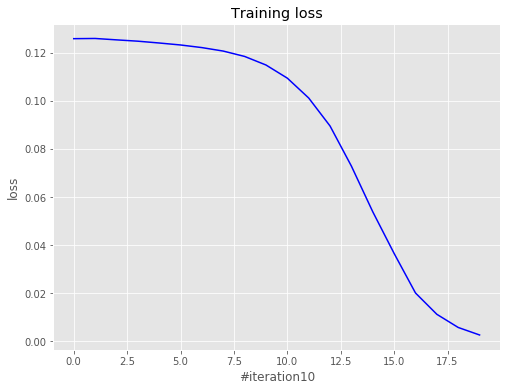

Current loss: 0.002644


In [188]:
train(X,Y,n_epoch,batch_size,lr,state,optim_method='sgd')

# Digit classification 

### Fetching the Dataset

In [189]:
if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r', allow_pickle=True) as data:
        train_images = data['X']
        train_labels = data['y']
else:
    mnist = fetch_openml("mnist_784")
    train_images, train_labels = mnist.data, mnist.target
    np.savez('mnist.npz', X=train_images, y=train_labels)

### One-hot Encoding the Labels
For one-hot encoding you can use sklearn's `OneHotEncoder` class.

In [190]:
enc = OneHotEncoder()
one_hot_y = enc.fit_transform(train_labels.reshape(-1, 1)).todense()

/home/levon/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


### Train Test Splitting

In [191]:
X_train = train_images[:10000]/255
y_train = one_hot_y[:10000]
y_train = np.array(y_train)
X_val = train_images[10000:15000]/255
y_val = one_hot_y[10000:15000]
y_val = np.array(y_val)

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_val', X_val.shape)
print('y_val', y_val.shape)


X_train (10000, 784)
y_train (10000, 10)
X_val (5000, 784)
y_val (5000, 10)


## Some baselines 

### Logistic Regression

In [16]:
lg = LogisticRegression(random_state=0,tol=0.00001).fit(X_train , train_labels[:10000])
print(lg.score(X_val,train_labels[10000:15000]))

/home/levon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/levon/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.888


### SVM

In [17]:
svr = SVC(gamma='auto')
svr.fit(X_train, train_labels[:10000])
svr.score(X_val,train_labels[10000:15000])

0.9104

### Gradient Boosting

In [18]:
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train, train_labels[:10000])
gb_clf.score(X_val, train_labels[10000:15000])

0.919

### Random Forest

In [19]:
rf = RandomForestClassifier(max_depth=7, random_state=0,n_estimators=50)
rf.fit(X_train, train_labels[:10000])
rf.score(X_val,train_labels[10000:15000])

0.8872

### KNN

In [20]:
neigh = KNeighborsClassifier()
neigh.fit(X_train, train_labels[:10000])
neigh.score(X_val,train_labels[10000:15000])

0.9426

### Training a NN

You can use the codes above.

I will try to use architecture of this paper, but more simple. https://arxiv.org/pdf/1003.0358.pdf

In [21]:
# TODO: Define Hyperparameters here
n_epoch = 25
batch_size = 512
lr = 0.00001
state= {}

In [22]:
# TODO: Define NN architecture 
criterion = CrossEntropyCriterion()

net = Sequential()
net.add(Linear(784, 2000))
net.add(Tanh())
net.add(Linear(2000, 1500))
net.add(Tanh())
net.add(Linear(1500, 1000))
net.add(Tanh())
net.add(Linear(1000, 500))
net.add(Tanh())
net.add(Linear(500, 10))
net.add(SoftMax())

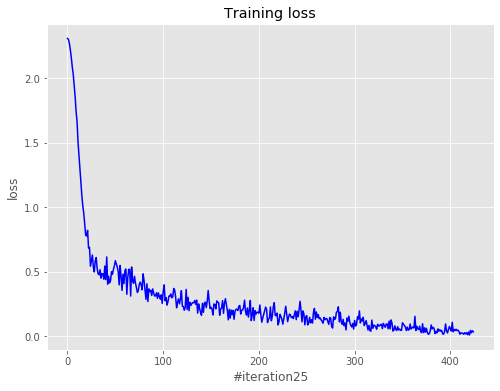

Current loss: 0.032080


In [23]:
train(X_train,y_train,n_epoch,batch_size,lr,state,optim_method='sgd')

### Evaluate on Test Dataset

### Train

In [26]:
net.evaluate()
pred = net.forward(X_train)
pred = np.argmax(pred, axis=1)
accuracy_score(pred, np.argmax(y_train, axis=1))

0.991

#### Test

In [27]:
net.evaluate()
pred = net.forward(X_val)
pred = np.argmax(pred, axis=1)
accuracy_score(pred, np.argmax(y_val, axis=1))

0.9258

# Using Dropout

In [204]:
# TODO: Define Hyperparameters here
n_epoch = 20
batch_size = 512
lr = 0.0001
state= {}

In [205]:
# TODO: Define NN architecture 
criterion = CrossEntropyCriterion()

net = Sequential()
net.add(Linear(784, 2000))
net.add(Tanh())
net.add(Linear(2000, 1000))
net.add(Tanh())
net.add(Linear(1000, 500))
net.add(Tanh())
net.add(Linear(500, 10))
net.add(SoftMax())

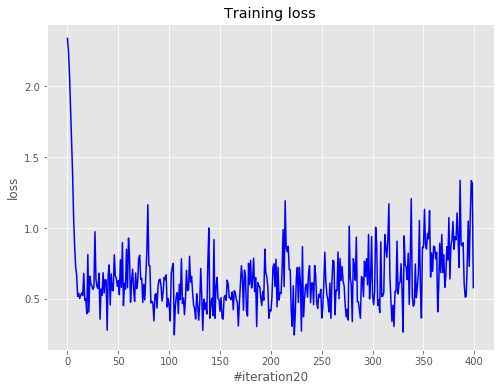

Current loss: 0.579780
CPU times: user 6min, sys: 3.75 s, total: 6min 4s
Wall time: 1min 1s


In [206]:
%%time
train(X_train,y_train,n_epoch,batch_size,lr,state)

# Train

In [207]:
net.evaluate()
pred = net.forward(X_train)
pred = np.argmax(pred, axis=1)
accuracy_score(pred, np.argmax(y_train, axis=1))

0.948

# Test

In [208]:
net.evaluate()
pred = net.forward(X_val)
pred = np.argmax(pred, axis=1)
accuracy_score(pred, np.argmax(y_val, axis=1))

0.9026

# Using SGD with Momentum

In [209]:
# TODO: Define Hyperparameters here
n_epoch = 20
batch_size = 1024
lr = 0.0001
state= {}

In [210]:
criterion = CrossEntropyCriterion()
net = Sequential()
net.add(Linear(784, 1800))
net.add(ReLU())
net.add(Dropout())
net.add(Linear(1800, 500))
net.add(ReLU())
net.add(Dropout())
net.add(Linear(500, 10))
net.add(SoftMax())

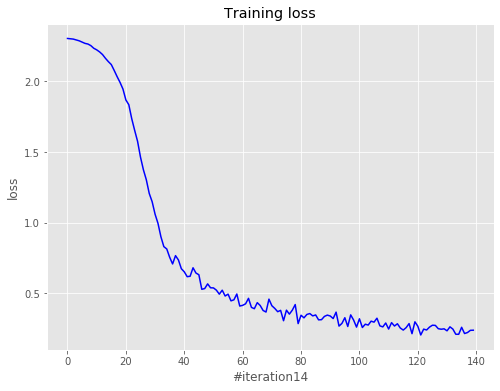

Current loss: 0.240495


KeyboardInterrupt: 

In [211]:
train(X_train,y_train,n_epoch,batch_size,lr,state,optim_method='sgd_momentum')

# Test

In [117]:
net.evaluate()
pred = net.forward(X_val)
pred = np.argmax(pred, axis=1)
accuracy_score(pred, np.argmax(y_val, axis=1))

0.949

# Train


In [73]:
net.evaluate()
pred = net.forward(X_train)
pred = np.argmax(pred, axis=1)
accuracy_score(pred, np.argmax(y_train, axis=1))

0.9849

## Other parameters

In [61]:
n_epoch = 60
batch_size = 1024
lr = 0.0001
state= {}

In [62]:
criterion = CrossEntropyCriterion()
net = Sequential()
net.add(Linear(784, 1800))
net.add(ReLU())
net.add(Dropout())
net.add(Linear(1800, 500))
net.add(ReLU())
net.add(Dropout())
net.add(Linear(500, 10))
net.add(SoftMax())

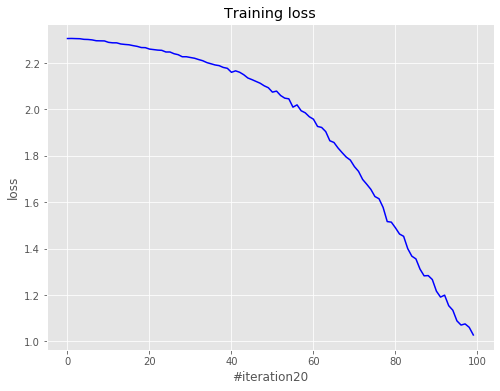

Current loss: 1.027608


In [63]:
train(X_train,y_train,n_epoch,batch_size,lr,state,optim_method='sgd_momentum')

## Train

In [38]:
net.evaluate()
pred = net.forward(X_train)
pred = np.argmax(pred, axis=1)
accuracy_score(pred, np.argmax(y_train, axis=1))

0.9828

## Test

In [39]:
net.evaluate()
pred = net.forward(X_val)
pred = np.argmax(pred, axis=1)
accuracy_score(pred, np.argmax(y_val, axis=1))

0.9424

# Using Adam

In [227]:
# TODO: Define Hyperparameters here
n_epoch = 25
batch_size = 256
lr = 0.001
state= {}

In [228]:
criterion = CrossEntropyCriterion()
net = Sequential()
net.add(Linear(784, 1800))
net.add(ReLU())
net.add(Dropout_Inverted())
net.add(Linear(1800, 500))
net.add(ReLU())
net.add(Dropout_Inverted())
net.add(Linear(500, 10))
net.add(SoftMax())

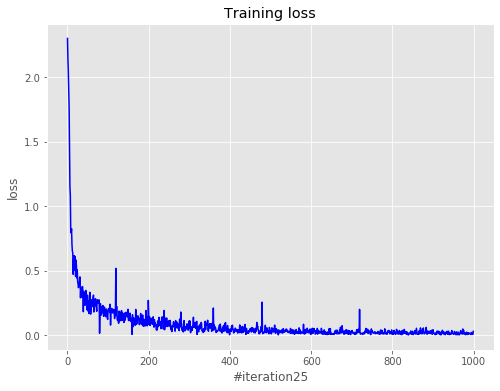

Current loss: 0.028317


In [229]:
train(X_train,y_train,n_epoch,batch_size,lr,state,optim_method='adam')

## Test

In [230]:
net.evaluate()
pred = net.forward(X_val)
pred = np.argmax(pred, axis=1)
accuracy_score(pred, np.argmax(y_val, axis=1))

0.956

In [239]:
# TODO: Define Hyperparameters here
n_epoch = 35
batch_size = 256
lr = 0.005
state= {}

In [240]:
criterion = CrossEntropyCriterion()
net = Sequential()
net.add(Linear(784, 1000))
net.add(ReLU())
net.add(Dropout_Inverted())
net.add(Linear(1000, 10))
net.add(SoftMax())

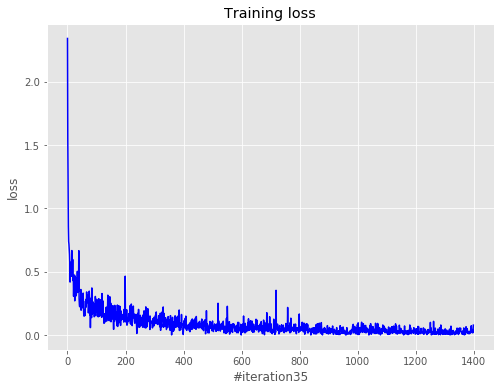

Current loss: 0.077920


In [241]:
train(X_train,y_train,n_epoch,batch_size,lr,state,optim_method='adam')

## Test

In [242]:
net.evaluate()
pred = net.forward(X_val)
pred = np.argmax(pred, axis=1)
accuracy_score(pred, np.argmax(y_val, axis=1))

0.9498